In [1]:
import jax
import numpy as np
import jax.numpy as jnp
import matplotlib.pyplot as plt
from jax.lax import fori_loop as jfori
from functools import partial
import pyext.src.plot as plot
from typing import Any
from sklearn.metrics import roc_curve, precision_recall_curve
State = Any
Output = Any
KeyArray = Any
DeviceArray = Any

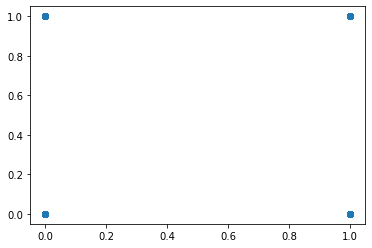

In [2]:
class StateLess:
    def stateless_method(state: State, *args, **kwargs) -> (State, Output):
        pass

# Funcitonal implementation
def cond_norm(key, y, rho, *args, **kwargs):
    return jax.random.normal(key) * jnp.sqrt(1 - rho **2) + y * rho

def cond_bern(key, p, shape):
    return jax.random.bernoulli(key, p, shape)

def cond_dist(key, dist, params, **kwargs):
    return dist(key, *params, **kwargs)


# X and Y are independant
def gibbsf(key: KeyArray, *args, N=10, thin=10,
           rho=0.5,
           **kwargs) -> DeviceArray:
    
    def outer_body_fun(i: int, val):
        key, samples, x, y, rho, thin  = val
        key, samples, x, y, rho, thin = jax.lax.fori_loop(0, thin, inner_body_fun, val)
        samples = samples.at[i].set([x, y])
        return key, samples, x, y, rho, thin

    def inner_body_fun(i: int, 
                       init_val
                       ) -> tuple[KeyArray, float, float]:
        
        key, samples, x, y, rho, thin = init_val
        key, k1, k2 = jax.random.split(key, 3)
        # x = jax.random.normal(k1) * jnp.sqrt(1 - rho **2) + y * rho
        # y = jax.random.normal(k2) * jnp.sqrt(1 - rho **2) + x * rho
        x = jax.random.bernoulli(k1, 0.5)
        y = jax.random.bernoulli(k2, 0.5)
        
        return key, samples, x, y, rho, thin
    
    # initiate
    key, k1, k2 = jax.random.split(key, 3)
    # x = jax.random.uniform(k1)
    # y = jax.random.uniform(k2)
    
    x = jax.random.bernoulli(k1)
    y = jax.random.bernoulli(k2)
    
    samples = jnp.zeros((N, 2))
    val = key, samples, x, y, rho, thin
    
    # key, samples, x, y, rho, thin
    samples = jax.lax.fori_loop(0, N, outer_body_fun, val)[1]
    return samples

# imperative implementation
def gibbs(key, N=10, thin=10):
    key, k1, k2 = jax.random.split(key, 3)
    x = jax.random.uniform(k1)
    y = jax.random.uniform(k2)
    samples = jnp.array(np.zeros((N, 2)))
    for i in range(N):
        for j in range(thin):
            key, k1, k2 = jax.random.split(key, 3)
            x = x_cond_dens(k1, y)
            y = y_cond_dens(k2, x)
        samples = samples.at[i].set([x, y])
    return samples


def make_gibbs_jit(sampler, rho, N, thin):
    gibbsf_partial = partial(sampler, N=N, thin=thin, rho=rho)
    gibbsf_jit = jax.jit(gibbsf_partial)
    return gibbsf_jit

gibbsf_jit = make_gibbs_jit(gibbsf, 0.99, 5000, 100)
key = jax.random.PRNGKey(5)
samples = np.array(gibbsf_jit(key))
x, y = samples[:, 0], samples[:, 1]
plot.scatter(x, y)

In [3]:
def get_probability_estimates(samples):
    return jnp.mean(samples, axis=0)

In [4]:
prob_estimate = get_probability_estimates(samples)

In [5]:
# Plot ROC and PRC curves
def ROC_PRC_test():
    key = jax.random.PRNGKey(10298)
    key, k1 , k2 = jax.random.split(key, 3)
    shape = (1000000, )
    y_true = jax.random.bernoulli(key, p=0.01, shape=shape)
    score = jax.random.uniform(k1, shape=shape)
    fpr, tpr, thresholds = roc_curve(y_true, score)
    precision, recall, pthresholds = precision_recall_curve(y_true, score)
    return fpr, tpr, thresholds, precision, recall, pthresholds

In [6]:
val = ROC_PRC_test()
fpr, tpr, thre, prec, recall, pthre = val

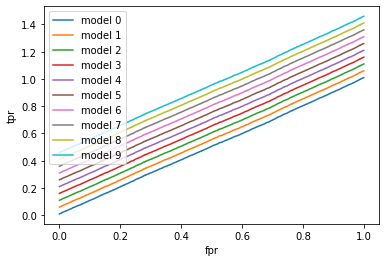

In [7]:
def multi_plot(fpr, tprm, xlabel='fpr', ylabel='tpr'):
    labels = []
    for e, i in enumerate(np.arange(0.01, 0.5, 0.05)):
        xi = tpr + i
        plt.plot(fpr, xi)
        label = f'model {e}'
        labels.append(label)
    plt.legend(labels)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

multi_plot(fpr, tpr)

ValueError: x and y must have same first dimension, but have shapes (942288,) and (120870,)

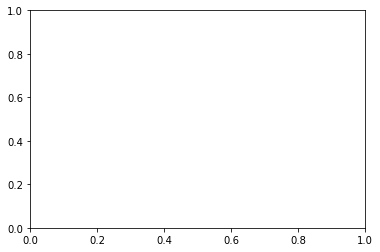

In [8]:
multi_plot(prec, recall)

In [10]:
recall.shape

(942288,)

In [19]:
def f3(k1, x):
    k1, k2 = jax.random.split(k1)
    n, x = f2(k1, x)
    u, x = f1(k2, x)
    return u, x
f3(testkey, 2)

(DeviceArray(0.85301065, dtype=float32), 2)

In [9]:
%%bash
conda list scikit-learn

# packages in environment at /home/aji/anaconda3/envs/pynetp3.10.0:
#
# Name                    Version                   Build  Channel


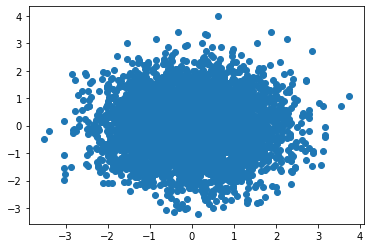

In [259]:
samples = gibbsf_jit(key, rho=0)
plot.scatter(samples[:, 0], samples[:, 1])

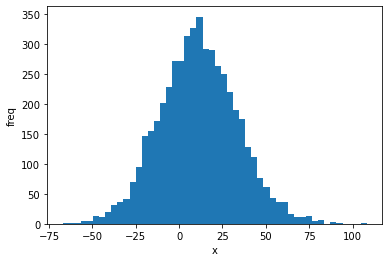

In [23]:
plot.marginal(x, xlabel='x')

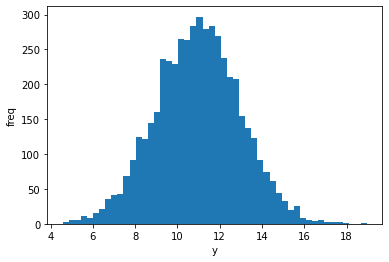

In [24]:
plot.marginal(y, xlabel='y')

In [229]:
# Metropolis Hastings


def mh_f(key, steps):
    
    def score(x):
        return jax.scipy.stats.logistic.pdf(x)

    def rv(key):
        return jax.random.uniform(key, minval=-10, maxval=10)

    def body(i, init):
        key, x = init
        x0 = x[i-1]
        key, g1, g2 = jax.random.split(key, 3)
        x1 = rv(g1)
        A = score(x1) / score(x0)
        p = jax.random.uniform(g2)
        xi = jax.lax.cond(p < A, lambda : x1, lambda : x0)
        x = x.at[i].set(xi)
        return key, x
    
    def silly(i, v):
        u, x = v
        w = u, x
        return w
    
    samples = jnp.zeros(steps)
    key, samples = jax.lax.fori_loop(1, steps, body, (key, samples))
    return samples

key = jax.random.PRNGKey(10)
key, j1 = jax.random.split(key, 2)
steps = 100000
mh_f(key, steps)

DeviceArray([0.        , 0.        , 0.        , ..., 0.12579441,
             0.12579441, 0.12579441], dtype=float32)

In [230]:
%timeit mh_f(key, steps)

610 ms ± 1.92 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [232]:
mh_fp = partial(mh_f, steps=100000)

In [236]:
mh_f_p_jit = jax.jit(mh_fp)

In [237]:
%timeit mh_f_p_jit(key).block_until_ready()

29.7 ms ± 507 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [241]:
jnp.all(mh_fp(key) == mh_f_p_jit(key))

DeviceArray(True, dtype=bool)

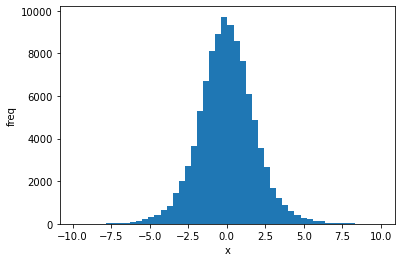

In [248]:
x = np.array(mh_f_p_jit(key))
plot.marginal(x)

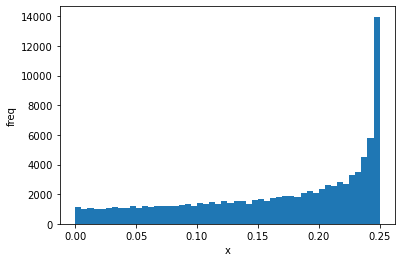

In [249]:
s = np.array(score(x))
plot.marginal(s)

array([2])

In [39]:
np.quantile(x, np.arange(0, 1, 0.1))

array([-67.20993805, -17.57506008,  -7.74843721,  -0.57580901,
         5.59279432,  10.89646578,  16.32335968,  22.66579857,
        29.87790794,  39.63228264])

In [35]:
np.arange(0, 1, 0.1)

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

In [4]:
k1 = jax.random.PRNGKey(23)
k2 = jax.random.PRNGKey(23)

In [11]:
%timeit gibbsf_jit(k1).block_until_ready()

160 ms ± 17.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [13]:
%timeit gibbs(k2, N=5000, thin=100)

59.9 s ± 37.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [5]:
def rel_error(x, s):
    return s / x

def error():
    r1 = rel_error(0.160, 0.0177)
    r2 = rel_error(59.9, 0.0373)
    r3 = r1 + r2
    return (59.9 / 0.160 ) * r3

jit:    160 ms ± 17.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
python: 59.9 s ± 37.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

jit compilation appeared to accelerate the gibbs sampler by 374 ± 42

In [9]:
jax.make_jaxpr(f)

NameError: name 'f' is not defined

In [ ]:
"""
# This code will take a very long time to jit compile
# because the gibbs function uses python for loops
# instead of jax.lax.fori_loop

gibbs_partial = partial(gibbs, N=50000, thin=1000)
gibbs_jit = jax.jit(gibbs_partial)
key = jax.random.PRNGKey(5)
samples = np.array(gibbs_jit(key))
plot.scatter(samples[:, 0], samples[:, 1])
"""

In [3]:
key = jax.random.PRNGKey(5)
gibbs_jit = jax.jit(gibbs)
samples = gibbs_jit(key)

In [4]:
key = jax.random.PRNGKey(5)
gibbsf_jit = jax.jit(gibbsf)
samplesf = gibbsf_jit(key)

In [7]:
key2 = jax.random.PRNGKey(17)
samples = gibbs_jit(key2)
key2 = jax.random.PRNGKey(17)
samplesf = gibbsf_jit(key2)

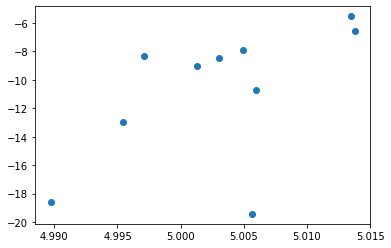

In [13]:
plt.scatter(samplesf[:, 0], samplesf[:, 1])

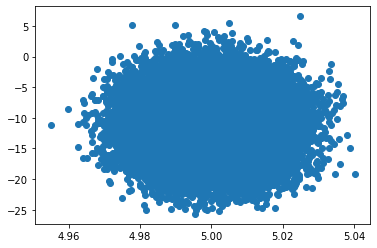

In [4]:
gibbs_partial = partial(gibbsf, N=50000, thin=1000)
gibbsf_jit = jax.jit(gibbs_partial)
key = jax.random.PRNGKey(5)
samples = np.array(gibbsf_jit(key))
plt.scatter(samples[:, 0], samples[:, 1])

In [14]:
x, y, z, *args = (1, 2, 3)

In [ ]:
try:  # Doesn't work; fori_loop requires f(i, val)
    f = lambda x: x+1
    jax.lax.fori_loop(0, 100, f, 0)
except TypeError:
    # Works
    # Can jit through the funciton
    def iwrapper(f):
        def wrap(i, val):
            return f(val)
        return wrap
    f = iwrapper(lambda x: x+1)
    print(jax.lax.fori_loop(0, 10, f, 0))
    print(jax.jit(lambda : jax.lax.fori_loop(0, 10, f, 0))().block_until_ready())

In [270]:
def f(x: KeyArray):
    def g(x):
        return 2*x
    return g(x) + 1
f = jax.jit(f)


In [80]:
def inner_body_fun(i: int, 
                   val: tuple[KeyArray, float, float]
                   ) -> tuple[KeyArray, float, float]:

    key, samples, x, y, thin = val
    key, k1, k2 = jax.random.split(key, 3)
    x = x_cond_dens(k1, y)
    y = y_cond_dens(k2, x)
    samples = samples.at[i].set([x, y])
    return key, samples, x, y, thin

key = jax.random.PRNGKey(10)
key, k1, k2 = jax.random.split(key, 3)
N = 1000
thin = 5
x = jax.random.uniform(k1)
y = jax.random.uniform(k2)
samples = jnp.zeros((N, 2))
val = key, samples, x, y, thin
def outer(val):
    return jax.lax.fori_loop(0, N, inner_body_fun, val)

opartial = partial(outer, val=val)
otest = jax.jit(opartial)

In [94]:
a, b, *args = (1, 2, 3)

In [185]:
def f1(x, y, *args, **kwargs):
    return x * y, args, kwargs

def f2(x, *args, **kwargs):
    rho = kwargs['rho']
    return x + rho, args, kwargs

def g(x, y, *args, **kwargs):
    a, args, kwargs = f1(x, y, *args, **kwargs)
    b, args, kwargs = f2(a, *args, **kwargs)
    return b, args, kwargs

def h(x, y, *args, **kwargs):
    return f2(f1(*args, **kwargs))
g(1, 2, **{'rho': 4})

(6, (), {'rho': 4})

In [100]:
# Suppose we have a set of functions a, b, c, ..., h
def local_block():
    def a(state: tuple[Any], x, y, *args, **kwargs):
        return state, (x + y, )

    def b(state: tuple[Any], x, *args, **kwargs):
        return state, (x, x ** 2 )

    def c(state: tuple[Any], x, y, *args, **kwargs):
        return state, (x + y, ), args, kwargs

    def d(state: tuple[Any], x, rho, *args, **kwargs):
        return state, (x - 10 * rho,)
    
    def e(state: tuple[Any], x, *args, **kwargs):
        return state, (x * 2, )
    
    def f(state: tuple[Any], x, *args, **kwargs):
        return state, (jnp.log(x), )
    
    def h(state: tuple[Any], x, *args, **kwargs):
        return state, (1 / 2 * x ** 2, )
    
    # We wish to compose and jit compile these functions into a pipe
    # output = h(e(d(c(b(a)))))
    # each function has positional[:tuple] and keyword[:dict] arguments
    # we would like to make a change in the middle of the chain without
    # affecting how we built the funciton before and after
    # how would we do this?
    
    # supposing the funcitons are pure
    
    # we must make a change to c
    # option1 : add an extra parameter to the highest level function
    # and a parameter to c without changing c's return type
    
    # c(x, y) -> c(x, y, z)
    # 
    
    def statless_function(state: State, *args, **kwargs) -> tuple[State, Output]:
        pass
    
    def pipe(state: tuple[Any], pipe_in, *args, **kwargs):
        state, return_a = a(state, *pipe_in)
        state, return_b = b(state, *return_a)
        state, return_c = c(state, *return_b)
        state, return_d = d(state, *return_c)
        state, return_e = e(state, *return_d)
        state, return_f = f(state, *return_e)
        state, pipe_out = h(state, *return_f)
        return state, pipe_out
    
    class P:
        def __lt__(self, div):
            print(div)
    
    state = (1, 2)
    pipe_in = (11, 12)
    p = P()
    p < pipe(state, pipe_in)
    #p < jax.make_jaxpr(a)((), np.array([1, 2]), np.array([1, 1]))
    p < jax.make_jaxpr(pipe)((1, 2), (11, 12))
    
        
local_block()

TypeError: local_block.<locals>.d() missing 1 required positional argument: 'rho'

In [107]:
def f(x, y, z, *args, file=None, **kwargs):
    print(file)
    return x, (y + z, ), args, kwargs

state, ret, args, kwargs = f(*(1, 2, 3, 4, 5), **{'j': 2, 'file':4})
state, ret, args, kwargs

4


(1, (5,), (4, 5), {'j': 2})

In [119]:
def f(state, *args, **kwargs):
    print(args)
    x = args[0]
    print(x)
    print(args)
    y = args[1]
    return args


def f(state, x, y, *args, **kwargs):
    ret_f = x + y
    return state_f, ret_f, args_f, kwargs_f


def producer(*args):
    return 1, 2

def middle(x, y, *args):
    print(x + y)
    print(args)
    return x + y, args
    
def consumer(z, *args):
    z = z**2
    print(z)
    print(args)
    return z



consumer(*middle(*producer()))

3
()
9
((),)


9

In [23]:
def f1(x, y, *args, **kwargs):
    return x * y, args, kwargs

def f2(x, *args, **kwargs):
    return x + 2
print(jax.make_jaxpr(f2)b)

<function f2 at 0x7f89881ed510>


In [24]:
jxp_f2 = jax.make_jaxpr(f2)

In [25]:
jxp_f2

<function __main__.f2(x, *args, **kwargs)>

In [175]:
g(1, 2, **{'rho': 10})

NameError: name 'rho' is not defined

In [176]:
def f(x, y, **kwargs):
    return x * y * rho

In [180]:
f(1, 2, **{'rho':10})

NameError: name 'rho' is not defined

In [195]:
m[9]

9